## Setup

In [1]:
!pip -q install transformers
!pip -q install evaluate
!pip -q install rouge_score

In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import torch
from torch import nn
import os
import itertools
from datetime import datetime
import time
import random
import pprint
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics

# Hugging Face
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate

# rich: for a better display on terminal
from rich.table import Column, Table
from rich import box
from rich.console import Console

# Network
import networkx as nx

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [3]:
CFG = {
    'show_examples': True,
    'data_dir': '/kaggle/input/drowsy-eye-keypoints',
    'seed': 719,
    'model_arch': "VietAI/vit5-base-vietnews-summarization",
    'text_len': 80,
    'batch_size': 4,
}

In [4]:
data_dir = '/kaggle/input/vims-dataset/ViMs'
original_dir = os.path.join(data_dir, 'original')
summary_dir = os.path.join(data_dir, 'summary')

## Utils

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [6]:
def read_txt(path, article_type, sent=False):
    content = []
    write_file = False
    with open(path) as f:
        for line in f:
            if article_type == "original":
                if line.lower().startswith("content"):
                    write_file = True
            else:
                write_file = True
            if write_file: 
                if line.rstrip():
                    content.append(line.rstrip())
    if sent:
        return content[1:]
    return " ".join(content[1:])
if CFG['show_examples']:
    path1 = '/kaggle/input/vims-dataset/ViMs/original/Cluster_001/original/10.txt'
    path2 = '/kaggle/input/vims-dataset/ViMs/summary/Cluster_001/0.gold.txt'
    print(read_txt(path2, article_type="summary", sent=True))

['Các chuyên gia hàng không lo ngại một hành động cố ý đã khiến máy bay biến mất khỏi màn hình radar.', 'Bộ trưởng Hàng không Ai Cập Sherif Fathy nghiêng về khả năng MS804 bị khủng bố nhiều hơn là trục trặc kỹ thuật.', 'Họ nghi ngờ một quả bom khiến máy bay nổ tung, sau đó rơi xuống biển.', 'Tổng thư ký Tổ chức Hiệp ước Bắc Đại Tây Dương Jens Stoltenberg cho biết sẽ hỗ trợ công tác tìm kiếm máy bay MS 804.', 'một cuộc điều tra quy mô lớn đang được tiến hành sau khi chiếc A320 biến mất.', 'Theo các nguồn tin, hải mảnh nhựa vỡ được tìm thấy có màu trắng và đỏ.', 'Những mảnh vỡ  được phát hiện ở gần khu vực nơi hệ thống định vị khẩn cấp trên máy bay đã phát tín hiệu trước đó.', '66 người được cho là đã chết khi chuyến bay MS804 biến mất.', 'Ezeddin Samar là nữ tiếp viên có mặt trên chuyến bay MS804.', 'Ngay sau sự cố, có người phát hiện ra cô từng đăng ảnh bên cạnh một máy bay bị chìm.']


## CSV File

In [7]:
def create_csv(data_dir):
    """
    Input: data_dir
    - dir format: data_dir/original/cluster/original/txt
    Output: csv
    """
    df = {'cluster':[], 'path':[]}
    for cluster in os.listdir(data_dir):
        file_type = data_dir[data_dir.rfind("/")+1:]
        if file_type == "original":
            f_path = os.path.join(data_dir, cluster, file_type)
        else:
            f_path = os.path.join(data_dir, cluster)
        for f in glob(f_path + '/*'):
            df['cluster'].append(cluster)
            df['path'].append(f)

    df = pd.DataFrame(df)
    df = df.groupby('cluster')['path'].apply(list).reset_index()
    return df

original_df = create_csv(original_dir)
original_df.columns = ['cluster', 'original_dir']

summary_df = create_csv(summary_dir)
summary_df.columns = ['cluster', 'summary_dir']

df = original_df.merge(summary_df, how='inner', on='cluster')
if CFG['show_examples']:
    print(len(df))
    print(len(df['cluster'].unique()))
    print(df.head())

300
300
       cluster                                       original_dir  \
0  Cluster_001  [/kaggle/input/vims-dataset/ViMs/original/Clus...   
1  Cluster_002  [/kaggle/input/vims-dataset/ViMs/original/Clus...   
2  Cluster_003  [/kaggle/input/vims-dataset/ViMs/original/Clus...   
3  Cluster_004  [/kaggle/input/vims-dataset/ViMs/original/Clus...   
4  Cluster_005  [/kaggle/input/vims-dataset/ViMs/original/Clus...   

                                         summary_dir  
0  [/kaggle/input/vims-dataset/ViMs/summary/Clust...  
1  [/kaggle/input/vims-dataset/ViMs/summary/Clust...  
2  [/kaggle/input/vims-dataset/ViMs/summary/Clust...  
3  [/kaggle/input/vims-dataset/ViMs/summary/Clust...  
4  [/kaggle/input/vims-dataset/ViMs/summary/Clust...  


## Representation of Sentences

In [8]:
tokenizer = AutoTokenizer.from_pretrained(CFG['model_arch'])
model = AutoModelForSeq2SeqLM.from_pretrained(CFG['model_arch'])
model = model.to(device)

In [9]:
def t5_embedding(text):
    ## Extract input ids
    input_ids = tokenizer(text,
                    max_length=CFG['text_len'],
                    pad_to_max_length=True,
                    truncation=True,
                    padding="max_length",
                    return_tensors="pt",
                   )['input_ids']
    
    ## Calculate embeddings
    embeddings = []
    for i in range(0, len(input_ids), CFG['batch_size']):
        batch = input_ids[i:i+CFG['batch_size']]
        emb = model.base_model.encoder(batch, return_dict=True).last_hidden_state
        embeddings.append(emb.detach())
    
    ## Stack embedding batches
    embeddings = torch.concat(embeddings)
    
    return embeddings

if CFG['show_examples']:
    idx = 10
    source_dir_list = df['original_dir'][idx]
    source_text = []
    for i in range(len(source_dir_list)):
        txt = read_txt(source_dir_list[i], article_type="original", sent=True)
        source_text += txt

    target_dir_list = df['summary_dir'][idx]
    target_text = read_txt(target_dir_list[0], article_type="summary")
    
    print("No. of sentences in article: ", len(source_text))
    embeddings = t5_embedding(source_text)
    print("Embedding size: ", embeddings.size())

No. of sentences in article:  26
Embedding size:  torch.Size([26, 80, 768])


## Similarity matrix

(26, 26)


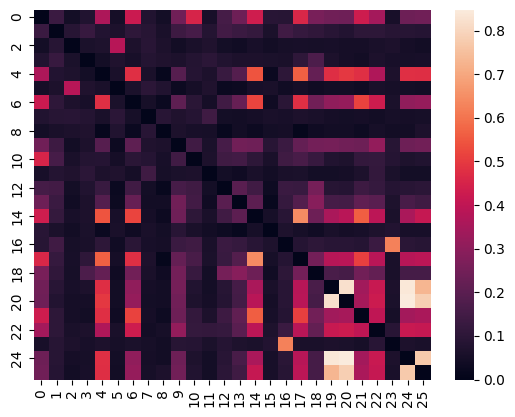

In [10]:
def sim_matrix(embeddings):
    mat_size = embeddings.shape[0]
    sim_mat = torch.zeros([mat_size, mat_size])
    for i in range(mat_size):
        for j in range(mat_size):
            if i != j:
                sent1 = embeddings[i,:].reshape(1,-1)
                sent2 = embeddings[j,:].reshape(1,-1)
                sim_mat[i][j] = F.cosine_similarity(sent1, sent2)
    sim_mat = sim_mat.detach().cpu().numpy()
    return sim_mat

if CFG['show_examples']:
    sim_mat = sim_matrix(embeddings)
    print(sim_mat.shape)
    sns.heatmap(sim_mat)

## Page Rank

In [11]:
source_text

['Ngày 19-5, tại Trung tâm Pháp y Đà Nẵng, Khoa Y dược, ĐH Đà Nẵng long trọng tổ chức lễ tri ân (Macchabée) những người đã hiến xác cho sự nghiệp đào tạo và nghiên cứu y khoa.',
 'Tại Lễ tri ân, những cán bộ, giảng viên và sinh viên Khoa Y dược thành kính dâng hoa, hương tưởng nhớ công lao những người thầm lặng hiến xác vì sự phát triển y học. Giải phẫu học là bộ môn xương sống trong đào tạo y khoa và những tiêu bản-thi hài phục vụ cho đào tạo rất quý giá và đáng trân trọng.',
 'Được biết, năm 2007, Khoa Y dược, ĐH Đà Nẵng phối hợp với ĐH Y Dược thành phố Hồ Chí Minh tuyển sinh đào tạo Y khoa. Từ năm 2008, khoa tiếp nhận 2 tiêu bản nhân thể từ ĐH Y Dược thành phố Hồ Chí Minh về đặt tại Bệnh viện Đà Nẵng và tiếp tục tiếp nhận 2 tiêu bản nhân thể mới. Bộ môn giải phẫu học được đưa vào giảng dạy thực hành cho sinh viên bác sĩ đa khoa, hệ liên thông, tại Khoa Y dược ĐH Đà Nẵng khóa 2011-2015 và khóa 2012-2016.',
 'Hơn 300 sinh viên khoa Y dược cùng thầy cô, cán bộ khoa đã có mặt tại lễ tri

In [12]:
target_text

'Sự đóng góp của những thi hài người hiến xác là rất lớn và có ý nghĩa đối với ngành y khoa. Các sinh viên cho biết, đã tự tay làm những đài sen bằng giấy để tỏ lòng tưởng nhớ, biết ơn những người hiến xác cho bộ môn Giải phẫu học. Đây là lần đầu tiên buổi lễ được tổ chức tại Đà Nẵng, với sự góp mặt của lãnh đạo, giảng viên cùng hơn 300 sinh viên.'

In [13]:
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(source_text)), reverse=True)
# Extract top 10 sentences as the summary
for i in range(15):
    print(ranked_sentences[i][1])

Sinh viên ngành Y dược rước hương án đến nơi đặt thi hài những người hiến xác.
Sinh viên Đà Nẵng tỏ lòng thành kính trong nghi lễ tri ân người hiến xác.
Ngày 19/5, Khoa Y dược (ĐH Đà Nẵng) tổ chức lễ Macchabée tri ân những người đã hiến xác cho công tác giáo dục và y khoa.
Hoa cúc vàng được sinh viên rải dọc trên lối dẫn vào nhà đặt thi hài.
Đại diện khoa Y dược, Đại học Đà Nẵng cho biết, những năm tiếp theo, trường sẽ tổ chức để tri ân những người hiến xác cho khoa học và giáo dục y đức cho sinh viên.
Lãnh đạo Khoa Y dược (ĐH Đà Nẵng) đọc văn tế tưởng nhớ những người hiến xác.
Theo đó, những người hiến xác đã âm thầm hi sinh quyền lợi của bản thân mình và gia đình cho sự nghiệp đào tạo và nghiên cứu y khoa.
Đây là lần đầu tiên ở Đà Nẵng có lễ Macchabée. Nghi lễ này bắt nguồn từ phương Tây vào khoảng đầu thế kỷ XVI mang tên một bác sỹ người Pháp có công lớn với bộ môn Giải phẫu học.
Bác sĩ Phan Bảo Khánh, Phó Chủ tịch Hội hình thể Việt Nam cho biết, những người hiến xác có thể có tên, 